# Model training and evaluation

In [ ]:
# Import standard libraries
import time
from pathlib import Path

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
from loguru import logger
from sklearn.compose import ColumnTransformer
from sklearn.model_selection import RandomizedSearchCV, train_test_split
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import OneHotEncoder, StandardScaler
from tqdm.notebook import tqdm
from xgboost import XGBRegressor

from nomination_predictor.config import MODELS_DIR, PROCESSED_DATA_DIR
from nomination_predictor.modeling.predict import (compare_models,
                                                   evaluate_and_report_model,
                                                   train_and_evaluate_model)
from nomination_predictor.modeling.train import save_model_with_metadata

In [ ]:
df = pd.read_csv(PROCESSED_DATA_DIR/"processed.csv")

# Verify GPU availability

In [ ]:
# Verify current GPU setup
import subprocess

import xgboost as xgb

print(f"📦 XGBoost version: {xgb.__version__}")

# Test GPU availability
try:
    result = subprocess.run(['nvidia-smi', '--query-gpu=name,memory.total', '--format=csv,noheader'], 
                          capture_output=True, text=True)
    if result.returncode == 0:
        print("✅ GPU detected:")
        for line in result.stdout.strip().split('\n'):
            print(f"  🔹 {line}")
    else:
        print("❌ nvidia-smi failed")
except FileNotFoundError:
    print("❌ nvidia-smi not found")

# Test XGBoost GPU support
try:
    test_model = xgb.XGBRegressor(tree_method="hist", device="cuda")
    print("✅ XGBoost GPU support confirmed with current syntax!")
except Exception as e:
    print(f"❌ XGBoost GPU issue: {e}")

📦 XGBoost version: 3.0.2
✅ GPU detected:
  🔹 NVIDIA GeForce RTX 3070, 8192 MiB
  🔹 NVIDIA GeForce RTX 2060, 6144 MiB
✅ XGBoost GPU support confirmed with current syntax!


# Choose features

## target variable

In [ ]:
TARGET = "days_nom_to_conf"

# pick target and drop Y label targets from features
y = df[TARGET]
X = df.drop(columns=[TARGET, "days_nom_to_latest_action"])  # other target saved for later tries at modeling

## numeric features

In [ ]:
NUMERIC_FEATURES = [
    "actions_count",
    "age_at_nom_days",
    "birth_year", 
    "committees_count",
    "congress_num", 
    "days_into_pres_term",
    "days_nom_to_deceased",
    "days_to_next_midterm_election",
    "days_to_next_pres_election",
    "death_year", 
    "degree_year", 
    "education_sequence", 
    "fed_service_sequence", 
    "highest_degree_level",
    "professional_career_sequence",
    "record_vote_number",   
    "service_as_chief_judge,_begin", 
    "service_as_chief_judge,_end",
]

# boolean features

In [ ]:
BOOLEAN_FEATURES = [
    "pres_term_is_latter_term", 
    "statute_authorized_new_seat_bool",
]

# categorical features

In [ ]:
CATEGORICAL_FEATURES  = [
    "aba_rating", 
    "appointing_president",
    "congress_session",
    "court_type",
    "birth_state",
    "latestaction_is_div_opp_house",
    "latestaction_is_div_opp_senate",
    "latestaction_is_fully_div",
    "latestaction_is_unified",
    "nomination_vacancy_reason",
    "nomination_of_or_from_location",
    "nomination_to_position_title",
    "nomination_to_court_name",
    "nominees_0_organization",
    "nominees_0_state",
    "nomination_term_years", # sounds numeric but only few options, including lifetime
    "party_of_appointing_president",
    "race_or_ethnicity",
    "received_in_senate_political_era",
    "school",
    "seat_level_cong_recategorized",
    "seat_id_letters_only",
    "senate_vote_type"
]

In [ ]:
from nomination_predictor.modeling.train import validate_feature_lists

are_features_unique = validate_feature_lists(NUMERIC_FEATURES, BOOLEAN_FEATURES, CATEGORICAL_FEATURES)

if not are_features_unique:
    raise ValueError("Feature lists contain duplicates. Please fix before continuing.")

✅ All features are unique across feature type lists
ℹ️ Total unique features: 43


In [ ]:
if len([col for col in NUMERIC_FEATURES if col not in df.columns]) > 0:
    logger.warning("The following columns in NUMERIC_FEATURES are absent from the df: {}".format(
        [col for col in NUMERIC_FEATURES if col not in df.columns],
    ))
if len([col for col in BOOLEAN_FEATURES if col not in df.columns]) > 0:
    logger.warning("The following columns in BOOLEAN_FEATURES are absent from the df: {}".format(
        [col for col in BOOLEAN_FEATURES if col not in df.columns],
    ))
if len([col for col in CATEGORICAL_FEATURES if col not in df.columns]) > 0:
    logger.warning("The following columns in CATEGORICAL_FEATURES are absent from the df: {}".format(
        [col for col in CATEGORICAL_FEATURES if col not in df.columns],
    ))

In [ ]:
cat_cols = df.select_dtypes("object").columns.tolist()
num_cols = [
    c for c in df.select_dtypes("number").columns
    if c not in {TARGET}
]

df_model = df[df[TARGET].notna()].copy()
X = df_model[BOOLEAN_FEATURES + CATEGORICAL_FEATURES + NUMERIC_FEATURES]
y = df_model[TARGET]

# splitting training and testing data

In [ ]:
from sklearn.model_selection import train_test_split

# Create composite strata
strata = (
    df_model["seat_level_cong_recategorized"].astype(str)
    + "__"
    + df_model["received_in_senate_political_era"].astype(str)
)

# Optionally collapse very-rare strata to 'Other' (prevents ValueError)
min_count = 3          # tweak as needed
rare_mask = strata.map(strata.value_counts()) < min_count
strata = strata.where(~rare_mask, other="Other")

# Train–test split
X_train, X_test, y_train, y_test = train_test_split(
    X,
    y,
    test_size=0.20,
    random_state=42,
    stratify=strata,
)

In [ ]:
# I'm normally accustomed to naming python constants with all-caps, but my code assist tools are insisting on making these lowercase, so we'll alias them just to appease it
numerical_features = NUMERIC_FEATURES
categorical_features = CATEGORICAL_FEATURES

# Model Selection, Training, and Evaluation

##  Preprocessing pipeline setup

Given how much data cleaning is(n't) happening so far, it's entirely possible the test data will contain something the training pipeline has never seen in the training data.

An example of an error message it threw when this occurred was `ValueError: Found unknown categories ['Syria', 'Russia', 'Trinidad and Tobago', 'Panama'] in column 4 during transform`, presumably because all of those were locations nominees have been appointed to work at or work with.

The simplest workaround is to ignore them until/unless enough feature-engineering can be done to re-bin them (e.g. by continent, or job type, etc.)

In [ ]:
# Fixed preprocessing pipeline
preprocessor = ColumnTransformer(
    transformers=[
        ('num', StandardScaler(), numerical_features),
        ('cat', OneHotEncoder(
            drop='first', 
            sparse_output=False,
            handle_unknown='ignore'  # 🔧 workaround for error described in a markdown cell above
        ), categorical_features)
    ]
)

## Untuned / naive pipeline

In [ ]:
baseline_pipeline = Pipeline([
    ('preprocessor', preprocessor),
    ('model', XGBRegressor(
        tree_method="hist",      # ✅ Current way
        device="cuda",           # ✅ Current way (replaces gpu_id, predictor, etc.)
        n_estimators=500,
        max_depth=6,
        learning_rate=0.1,
        random_state=42,
        n_jobs=-1
    ))
])

## Training & Evaluation

### Choice of metric: MAE

Mean Squared Error (MSE) and Root Mean Squared Error (RMSE) are both sensitive to outliers, and MSE also doesn't use the same units as our target variable, making it less intuitive.

After all our data cleaning, we have few-enough rows of data, with outliers occurring often-enough, that I'm selecting Mean Absolute Error (MAE) as our metric.

In [ ]:
# Train and evaluate baseline model
baseline_results = train_and_evaluate_model(
    model=baseline_pipeline,  # ✅ Use the actual pipeline variable name
    X_train=X_train,
    X_test=X_test,
    y_train=y_train,
    y_test=y_test,
    model_name="XGBoost Baseline",
    show_progress=True
)

2025-07-18 14:38:38.254 | INFO     | nomination_predictor.modeling.predict:train_and_evaluate_model:46 - Training XGBoost Baseline on 1424 samples, 43 features


Training XGBoost Baseline: 100%|██████████| 1/1 [00:03<00:00,  3.66s/it]


2025-07-18 14:38:41.918 | INFO     | nomination_predictor.modeling.predict:train_and_evaluate_model:58 - Training completed in 3.66 seconds


Making predictions:   0%|          | 0/2 [00:00<?, ?it/s]/home/wsl2ubuntuuser/.virtualenvs/nomination_predictor/lib/python3.12/site-packages/sklearn/preprocessing/_encoders.py:246: UserWarning: Found unknown categories in columns [4, 9, 11, 12, 17, 19] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(
Making predictions: 100%|██████████| 2/2 [00:00<00:00, 16.94it/s]


## Saving with evaluation metadata

In [ ]:
baseline_final = evaluate_and_report_model(
    results=baseline_results,
    y_train=y_train,
    y_test=y_test,
    model_name="XGBoost Baseline",
    save_model=True,
    hyperparameters={
        "n_estimators": 500,
        "max_depth": 6,
        "learning_rate": 0.1,
        "random_state": 42,
        "tree_method": "hist",
        "device": "cuda"
    }
)


📊 XGBOOST BASELINE EVALUATION RESULTS

🎯 PERFORMANCE METRICS:
  • Training MAE: 10.46 days
  • Test MAE:     47.05 days
  • Training R²:  0.9693
  • Test R²:      0.3599
  • Training time: 3.66 seconds

===== Mean Absolute Error (MAE): 47.05 =====
📊 GOOD: The model's predictions are typically within 60 days of the actual confirmation time.
🔍 TAKEAWAY: The model provides valuable insights but has moderate error margins.

===== R² Score: 0.3599 =====
📊 FAIR: The model explains between 30-50% of the variance in confirmation times.
🔍 TAKEAWAY: The model identifies some patterns but misses many important factors.

===== Interpretation in Context =====
• The average nomination takes 126 days to confirm
• With a standard deviation of 85 days
• Our model's error (MAE) is 47 days, which is 55% of the standard deviation
• This means our model outperforms a baseline model that always predicts the average

===== Recommended Next Steps =====
1. Tune hyperparameters to optimize model performance
2.

# Model tuning via randomized hyper-parameter search

## Define hyperparameter search space

In [ ]:
param_distributions = {
    'model__n_estimators': [100, 500, 1000, 2000, 3000, 6000],
    'model__max_depth': [3, 4, 5, 6, 7, 8, 9],
    'model__learning_rate': [0.01, 0.05, 0.1, 0.2],
    'model__subsample': [0.7, 0.8, 0.9, 1.0],
    'model__colsample_bytree': [0.7, 0.8, 0.9, 1.0],
    'model__reg_alpha': [0, 0.1, 0.5, 1.0],
    'model__reg_lambda': [0, 0.1, 0.5, 1.0],
    'model__min_child_weight': [1, 3, 5, 7],
    'model__gamma': [0, 0.1, 0.2, 0.3]
}

## Tuned pipeline

In [ ]:

tuned_pipeline = Pipeline([
    ('preprocessor', preprocessor),  # Same fixed preprocessor
    ('model', XGBRegressor(
        tree_method="hist",      # ✅ Current way
        device="cuda",           # ✅ Current way
        random_state=42,
        n_jobs=-1
    ))
])

## Randomized search

In [ ]:
print("🚀 Starting GPU-accelerated hyperparameter search...")
random_search = RandomizedSearchCV(
    tuned_pipeline,
    param_distributions=param_distributions,
    n_iter=20,
    cv=3,
    scoring='neg_mean_absolute_error',
    n_jobs=1,   # ⚠️ Still important: Set to 1 for GPU
    random_state=42,
    verbose=1
)

🚀 Starting GPU-accelerated hyperparameter search...


## Search-fitting

In [ ]:
random_search.fit(X_train, y_train)
print(f"✅ Best cross-validation score: {-random_search.best_score_:.2f} MAE")
print(f"🎯 Best parameters: {random_search.best_params_}")

Fitting 3 folds for each of 20 candidates, totalling 60 fits


/home/wsl2ubuntuuser/.virtualenvs/nomination_predictor/lib/python3.12/site-packages/sklearn/preprocessing/_encoders.py:246: UserWarning: Found unknown categories in columns [1, 4, 9, 11, 12, 13, 17, 19, 21] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(
/home/wsl2ubuntuuser/.virtualenvs/nomination_predictor/lib/python3.12/site-packages/sklearn/preprocessing/_encoders.py:246: UserWarning: Found unknown categories in columns [0, 4, 9, 12, 17, 19, 21] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(
/home/wsl2ubuntuuser/.virtualenvs/nomination_predictor/lib/python3.12/site-packages/sklearn/preprocessing/_encoders.py:246: UserWarning: Found unknown categories in columns [1, 4, 9, 10, 11, 12, 14, 17, 19, 21] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(
/home/wsl2ubuntuuser/.virtualenvs/nomination_predictor/lib/python3.12/site-packages/sklearn/preprocessing/_encoders.

✅ Best cross-validation score: 43.76 MAE
🎯 Best parameters: {'model__subsample': 0.8, 'model__reg_lambda': 0.5, 'model__reg_alpha': 1.0, 'model__n_estimators': 2000, 'model__min_child_weight': 3, 'model__max_depth': 8, 'model__learning_rate': 0.01, 'model__gamma': 0.3, 'model__colsample_bytree': 0.7}


## Evaluating best model found

In [ ]:
tuned_results = train_and_evaluate_model(
    model=random_search.best_estimator_,  # ✅ Use the best estimator from search; search is the object, not pipeline, because did randomized search
    X_train=X_train,
    X_test=X_test,
    y_train=y_train,
    y_test=y_test,
    model_name="XGBoost Tuned",
    show_progress=True
)

2025-07-18 14:49:56.841 | INFO     | nomination_predictor.modeling.predict:train_and_evaluate_model:46 - Training XGBoost Tuned on 1424 samples, 43 features


Training XGBoost Tuned: 100%|██████████| 1/1 [00:14<00:00, 14.29s/it]


2025-07-18 14:50:11.141 | INFO     | nomination_predictor.modeling.predict:train_and_evaluate_model:58 - Training completed in 14.30 seconds


Making predictions:  50%|█████     | 1/2 [00:00<00:00,  5.11it/s]/home/wsl2ubuntuuser/.virtualenvs/nomination_predictor/lib/python3.12/site-packages/sklearn/preprocessing/_encoders.py:246: UserWarning: Found unknown categories in columns [4, 9, 11, 12, 17, 19] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(
Making predictions: 100%|██████████| 2/2 [00:00<00:00,  5.51it/s]


## Saving and Reporting

In [ ]:
tuned_final = evaluate_and_report_model(
    results=tuned_results,
    y_train=y_train,
    y_test=y_test,
    model_name="XGBoost Tuned",
    save_model=True,
    hyperparameters=random_search.best_params_ 
)


📊 XGBOOST TUNED EVALUATION RESULTS

🎯 PERFORMANCE METRICS:
  • Training MAE: 9.59 days
  • Test MAE:     42.65 days
  • Training R²:  0.9747
  • Test R²:      0.4811
  • Training time: 14.30 seconds

===== Mean Absolute Error (MAE): 42.65 =====
📊 GOOD: The model's predictions are typically within 60 days of the actual confirmation time.
🔍 TAKEAWAY: The model provides valuable insights but has moderate error margins.

===== R² Score: 0.4811 =====
📊 FAIR: The model explains between 30-50% of the variance in confirmation times.
🔍 TAKEAWAY: The model identifies some patterns but misses many important factors.

===== Interpretation in Context =====
• The average nomination takes 126 days to confirm
• With a standard deviation of 85 days
• Our model's error (MAE) is 43 days, which is 50% of the standard deviation
• This means our model outperforms a baseline model that always predicts the average

===== Recommended Next Steps =====
1. Tune hyperparameters to optimize model performance
2. Ex

# Model comparison

In [43]:
# Compare both models using our comparison function
compare_models(
    results_list=[baseline_results, tuned_results],
    model_names=["XGBoost Baseline", "XGBoost Tuned"]
)

# Display model paths for reference
print(f"\n📁 SAVED MODELS:")
print(f"  • Baseline: {baseline_final['model_path']}")
print(f"  • Tuned:    {tuned_final['model_path']}")

# Show interpretation categories
print(f"\n🏷️ MODEL QUALITY ASSESSMENT:")
print(f"  • Baseline: {baseline_final['interpretation']['overall_quality']}")
print(f"  • Tuned:    {tuned_final['interpretation']['overall_quality']}")

# Feature importance analysis (if desired)
best_model = tuned_final['model']
if hasattr(best_model, 'feature_importances_') or hasattr(best_model[-1], 'feature_importances_'):
    print(f"\n🔍 TOP 10 MOST IMPORTANT FEATURES:")
    
    # Get feature names after preprocessing
    feature_names = best_model[:-1].get_feature_names_out()
    
    # Get feature importances
    if hasattr(best_model, 'feature_importances_'):
        importances = best_model.feature_importances_
    else:
        importances = best_model[-1].feature_importances_
    
    # Create feature importance DataFrame
    feature_importance_df = pd.DataFrame({
        'feature': feature_names,
        'importance': importances
    }).sort_values('importance', ascending=False)
    
    # Display top 10
    for i, (_, row) in enumerate(feature_importance_df.head(10).iterrows()):
        print(f"  {i+1:2d}. {row['feature']:<30} {row['importance']:.4f}")


📊 MODEL COMPARISON
Model                Train MAE    Test MAE     Train R²   Test R²    Time (s)  
--------------------------------------------------------------------------------
XGBoost Baseline     10.46        47.05        0.9693     0.3599     3.66      
XGBoost Tuned        9.59         42.65        0.9747     0.4811     14.30     
--------------------------------------------------------------------------------
🏆 Best model: XGBoost Tuned (Test MAE: 42.65 days)
📈 Improvement over baseline: 9.4% (47.05 → 42.65 days)

📁 SAVED MODELS:
  • Baseline: /home/wsl2ubuntuuser/nomination_predictor/models/xgboost_baseline_2025-07-18_143842.pkl
  • Tuned:    /home/wsl2ubuntuuser/nomination_predictor/models/xgboost_tuned_2025-07-18_145011.pkl

🏷️ MODEL QUALITY ASSESSMENT:
  • Baseline: good_performance
  • Tuned:    good_performance

🔍 TOP 10 MOST IMPORTANT FEATURES:
   1. num__congress_num              0.0183
   2. cat__appointing_president_Joseph R. Biden 0.0166
   3. cat__school_university

## Visualization

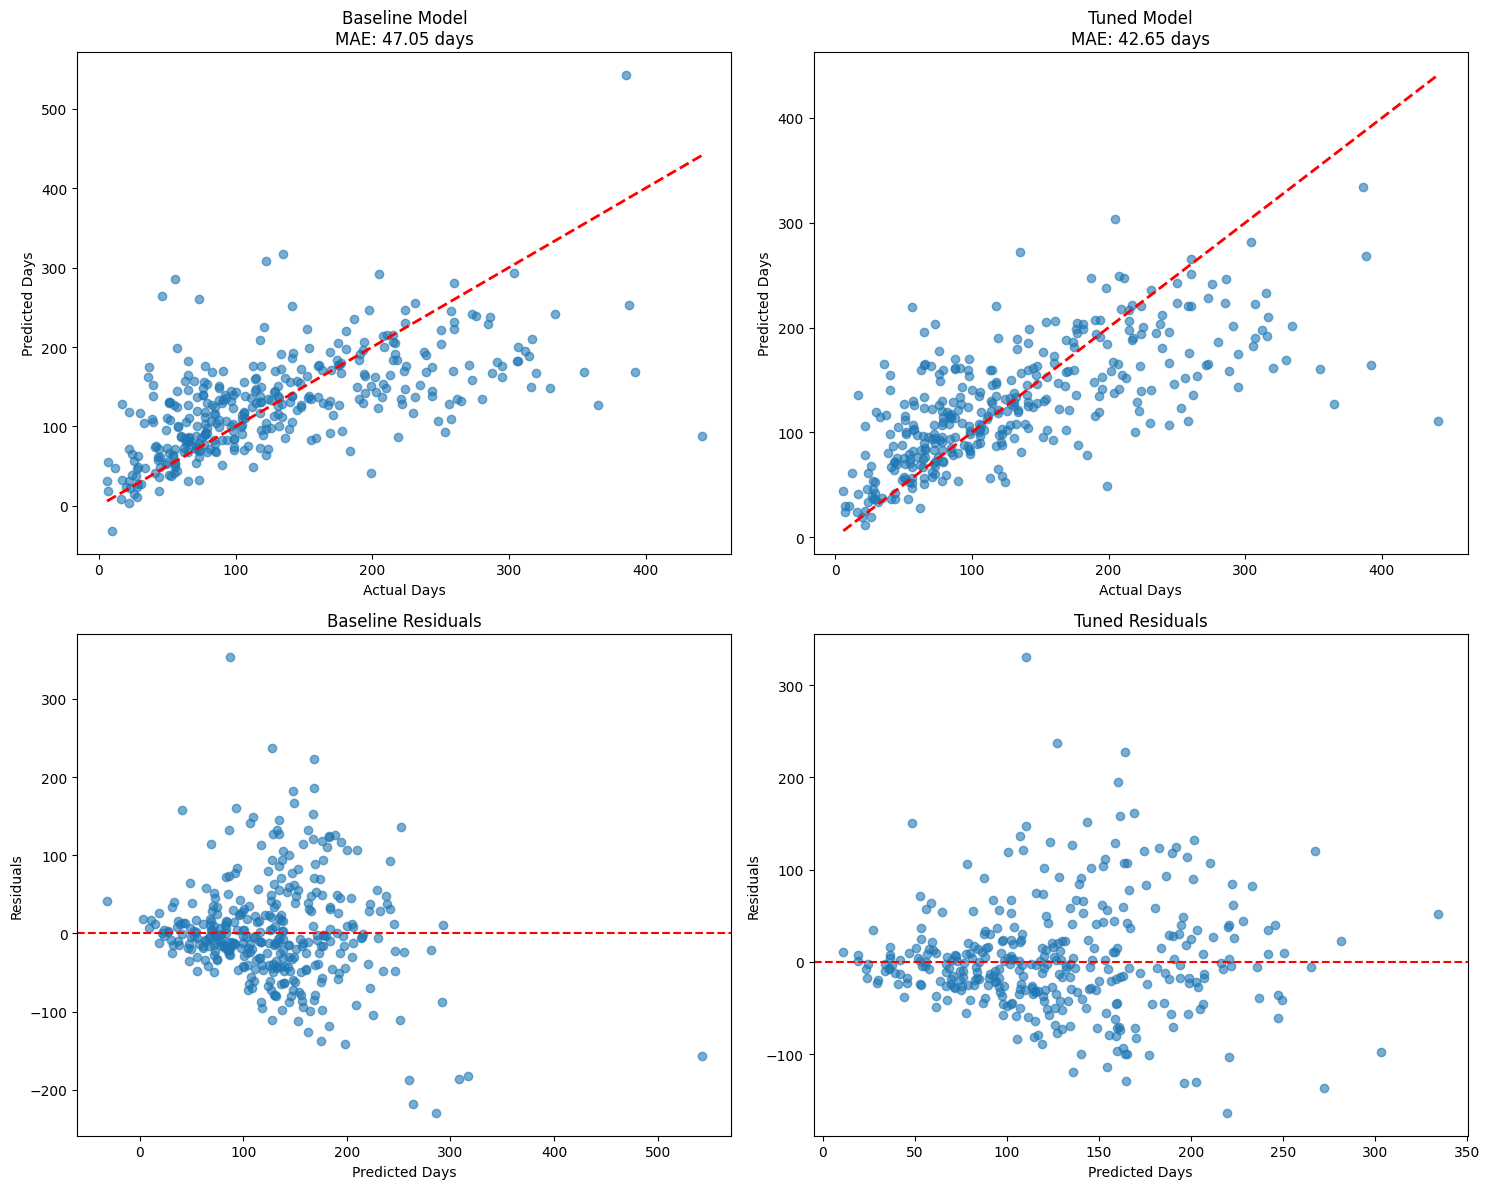

In [ ]:
# Create visualizations
fig, axes = plt.subplots(2, 2, figsize=(15, 12))

# 1. Actual vs Predicted (Baseline)
axes[0, 0].scatter(y_test, baseline_results['predictions']['y_test_pred'], alpha=0.6)
axes[0, 0].plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], 'r--', lw=2)
axes[0, 0].set_xlabel('Actual Days')
axes[0, 0].set_ylabel('Predicted Days')
axes[0, 0].set_title(f'Baseline Model\nMAE: {baseline_results["metrics"]["test_mae"]:.2f} days')

# 2. Actual vs Predicted (Tuned)
axes[0, 1].scatter(y_test, tuned_results['predictions']['y_test_pred'], alpha=0.6)
axes[0, 1].plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], 'r--', lw=2)
axes[0, 1].set_xlabel('Actual Days')
axes[0, 1].set_ylabel('Predicted Days')
axes[0, 1].set_title(f'Tuned Model\nMAE: {tuned_results["metrics"]["test_mae"]:.2f} days')

# 3. Residuals (Baseline)
baseline_residuals = y_test - baseline_results['predictions']['y_test_pred']
axes[1, 0].scatter(baseline_results['predictions']['y_test_pred'], baseline_residuals, alpha=0.6)
axes[1, 0].axhline(y=0, color='r', linestyle='--')
axes[1, 0].set_xlabel('Predicted Days')
axes[1, 0].set_ylabel('Residuals')
axes[1, 0].set_title('Baseline Residuals')

# 4. Residuals (Tuned)
tuned_residuals = y_test - tuned_results['predictions']['y_test_pred']
axes[1, 1].scatter(tuned_results['predictions']['y_test_pred'], tuned_residuals, alpha=0.6)
axes[1, 1].axhline(y=0, color='r', linestyle='--')
axes[1, 1].set_xlabel('Predicted Days')
axes[1, 1].set_ylabel('Residuals')
axes[1, 1].set_title('Tuned Residuals')

plt.tight_layout()
plt.show()